# Interpolation-based crunchers

This cruncher simply interpolates a straight line between the points in the plot of all leader and all follower. It has a wrapper that pre-filters the infiller data to such that it only uses data from scenarios or models containing a specified string (typically scenarios which start with "SSP"). This can be done with any of the models by filtering the data before it is put in, but is explicitly included as a possible parameter in this cruncher because here more data makes the cruncher more chaotic, whereas most crunchers benefit from more data. 

## Imports

In [1]:
import os.path
import traceback

import pandas as pd
import pyam
import matplotlib.pyplot as plt
import numpy as np

import silicone.database_crunchers
from silicone.utils import (
    _get_unit_of_variable,
    find_matching_scenarios,
    _make_interpolator,
    _make_wide_db,
    download_or_load_sr15,
)

valid_model_ids = [
    "MESSAGE*",
    "AIM*",
    "C-ROADS*",
    "GCAM*",
    "WITCH*",
]
sr15_data = download_or_load_sr15("./sr15_scenarios.csv", valid_model_ids)

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file sr15_scenarios.csv


## Interpolate specified scenarios and models
This cruncher filters the data for named models and scenarios. It then calls the "Interpolation" cruncher (which can also be called directly). The docstrings for these can both be read below.

In [2]:
print(silicone.database_crunchers.ScenarioAndModelSpecificInterpolate.__doc__)


    Database cruncher which pre-filters to only use data from specific scenarios, then
    runs the interpolation cruncher to return values from that set of scenarios. See the
    documentation of Interpolation for more details.
    


In [3]:
print(silicone.database_crunchers.Interpolation.__doc__)


    Database cruncher which uses interpolation.

    This cruncher derives the relationship between two variables by simply (usually
    linearly) interpolating between values in the cruncher database. It does not do any
    smoothing and is best-suited for smaller databases. Non-linear interpolation options
    are also available, including PCHIP interpolation.

    In the case where there is more than one value of the follower variable for a
    given value of the leader variable, the average will be used. For example, if
    one scenario has CH4 emissions of 10 MtCH4/yr whilst another has CH4
    emissions of 20 MtCH4/yr in 2020 whilst both scenarios have CO2 emissions
    of exactly 15 GtC/yr in 2020, the interpolation will use the average value from the
    two scenarios i.e. 15 Mt CH4/yr.

    Beyond the bounds of input data, the interpolation is held constant.
    For example, if the maximum CO2 emissions in 2020 in the database is
    25 GtC/yr, and CH4 emissions for this leve

## Using only one model

We will compare infilling using a database comprised of data only from variants of the MESSAGE models against AIM models. 

In [4]:
sr15_data_message = sr15_data.filter(
    model=["MESSAGE*"],
    variable=[
        "Emissions|CO2",
        "Emissions|VOC",
        "Emissions|CH4",
        "Emissions|HCF*",
    ],
)
sr15_data_message.model

['MESSAGE V.3', 'MESSAGE-GLOBIOM 1.0', 'MESSAGEix-GLOBIOM 1.0']

As we see below, variants of the MESSAGE model have submitted data for a large number of scenarios.

In [5]:
len(sr15_data_message.scenario)

58

For our example, we will infill data using data taken only from variants of the AIM model and we are only going to infill data for variants of SSP2.

In [6]:
sr15_data_aim_ssp2 = sr15_data.filter(
    model=["AIM*"],
    scenario="SSP2*",
    variable=[
        "Emissions|CO2",
        "Emissions|VOC",
        "Emissions|CH4",
        "Emissions|HCF*",
    ],
    year=sr15_data_message.data["year"].unique(),
)
sr15_data_aim_ssp2.model

['AIM/CGE 2.0']

In [7]:
len(sr15_data_aim_ssp2.scenario)

6

Although the lineshapes for CO$_2$ (left-hand column below) look similar in the AIM and MESSAGE models, the lineshapes for VOC (right-hand column below) are very different. 

<AxesSubplot:title={'center':'region: World - variable: Emissions|VOC'}, xlabel='Year', ylabel='Mt VOC/yr'>

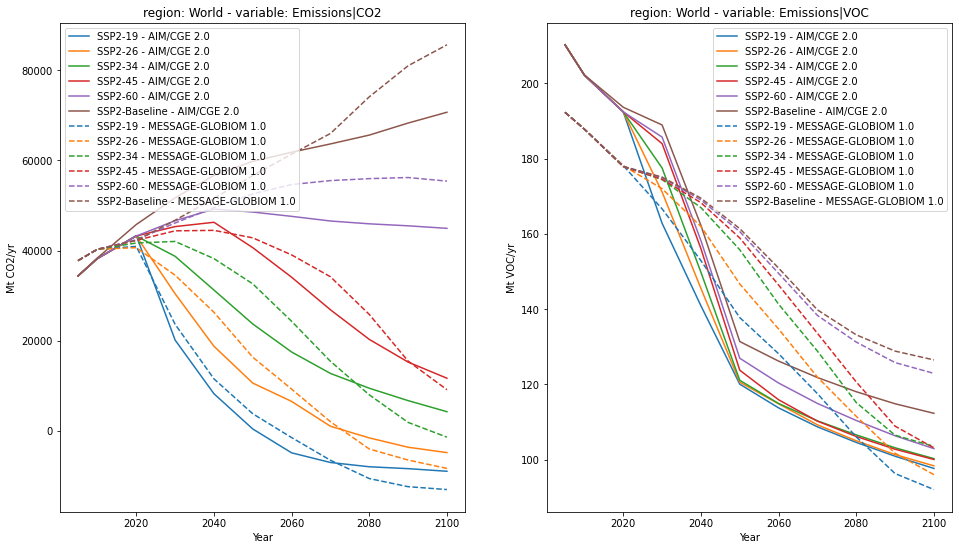

In [8]:
pdf = pyam.concat([sr15_data_message, sr15_data_aim_ssp2])

fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(121)
pdf.filter(scenario="SSP2*", variable="*CO2").plot(
    ax=ax, color="scenario", linestyle="model"
)

ax = fig.add_subplot(122)
pdf.filter(scenario="SSP2*", variable="*VOC").plot(
    ax=ax, color="scenario", linestyle="model"
)

Variants of the MESSAGE model have submitted data for many scenarios, but this cruncher allows us to specify that only data from scenarios which start with SSP2 should be used. 

In [9]:
cruncher = silicone.database_crunchers.ScenarioAndModelSpecificInterpolate(
    sr15_data_message
)
filler = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], required_scenario="SSP2*"
)
infilled = filler(sr15_data_aim_ssp2)

We can now compare the original data, the database which was used to derive the infilling relationship and the infilled data. We see that the infilled results result in timeseries which much more strongly resemble the timeseries in the database (i.e. the similarity in CO$_2$ emissions is now also reflected in VOC emissions). We also see that no emissions values more extreme than the range of values contained in the input database are returned by this cruncher.

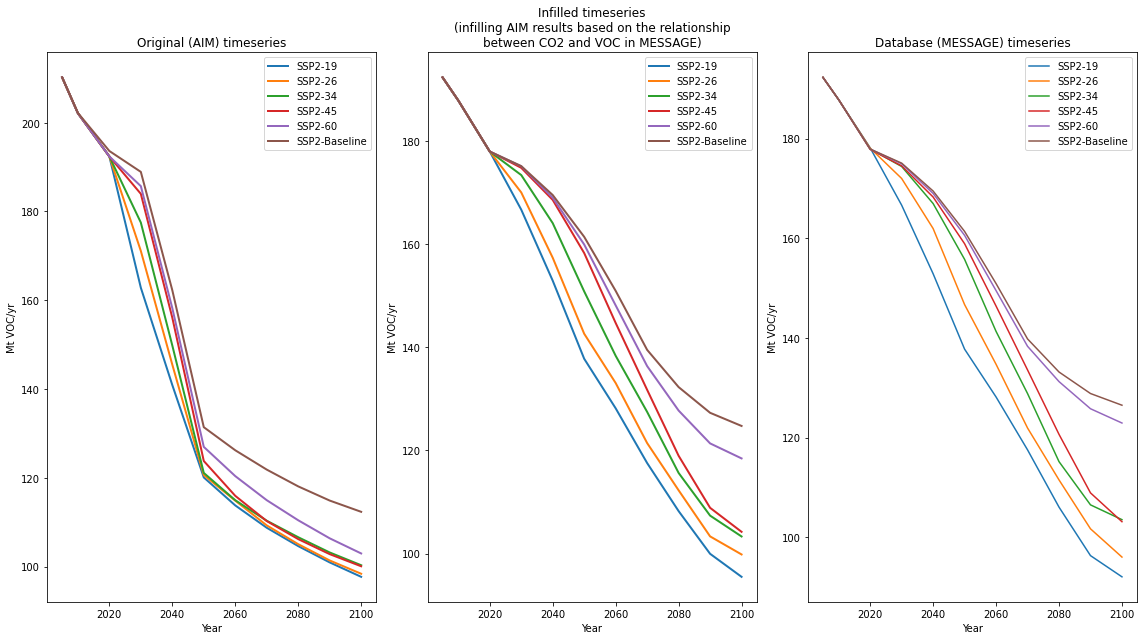

In [10]:
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(131)
sr15_data_aim_ssp2.filter(variable="*VOC").plot(ax=ax, **pkwargs)
ax.set_title("Original (AIM) timeseries")

ax = fig.add_subplot(132)
infilled.plot(ax=ax, **pkwargs)
ax.set_title(
    "Infilled timeseries\n(infilling AIM results based on the relationship\nbetween CO2 and VOC in MESSAGE)"
)

ax = fig.add_subplot(133)
sr15_data_message.filter(scenario="SSP2*", variable="*VOC").plot(
    ax=ax, color="scenario"
)
ax.set_title("Database (MESSAGE) timeseries")

plt.tight_layout()

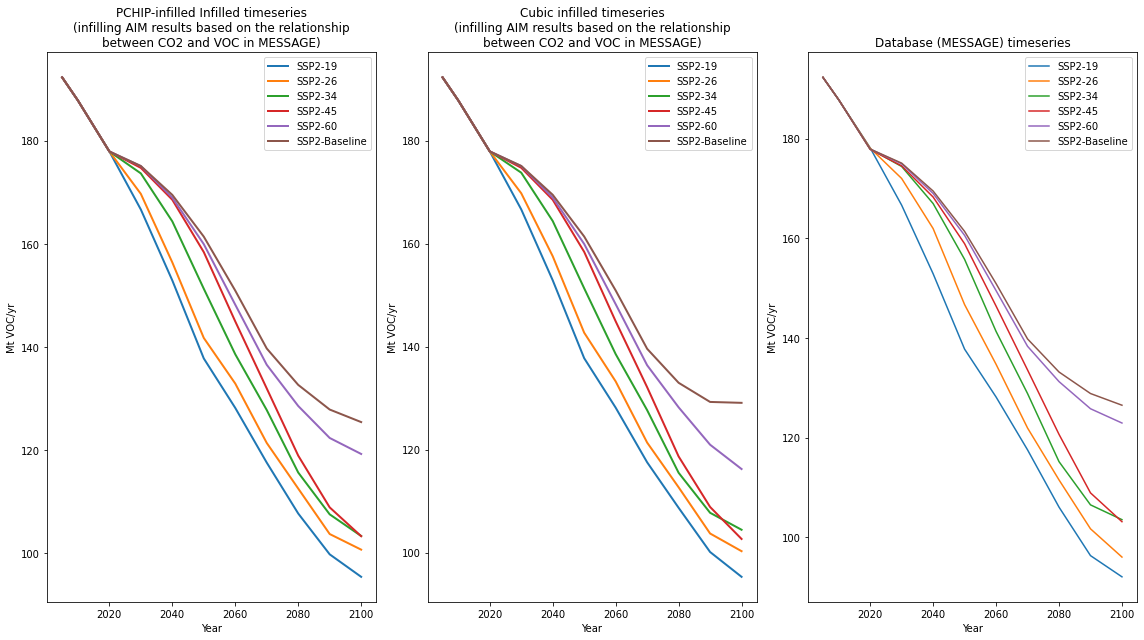

In [11]:
cubic_filler = filler = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], required_scenario="SSP2*", interpkind="cubic"
)
cubic_infilled = cubic_filler(sr15_data_aim_ssp2)
PCHIP_filler = filler = cruncher.derive_relationship(
    "Emissions|VOC",
    ["Emissions|CO2"],
    required_scenario="SSP2*",
    interpkind="PchipInterpolator",
)
PCHIP_infilled = PCHIP_filler(sr15_data_aim_ssp2)


pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(131)
PCHIP_infilled.filter(variable="*VOC").plot(ax=ax, **pkwargs)
ax.set_title(
    "PCHIP-infilled Infilled timeseries\n(infilling AIM results based on the relationship\nbetween CO2 and VOC in MESSAGE)"
)

ax = fig.add_subplot(132)
cubic_infilled.plot(ax=ax, **pkwargs)
ax.set_title(
    "Cubic infilled timeseries\n(infilling AIM results based on the relationship\nbetween CO2 and VOC in MESSAGE)"
)

ax = fig.add_subplot(133)
sr15_data_message.filter(scenario="SSP2*", variable="*VOC").plot(
    ax=ax, color="scenario"
)
ax.set_title("Database (MESSAGE) timeseries")

plt.tight_layout()

We see that the infilled values strongly resembles the infiller data in terms of lineshape, and (if linear or PCHIP infilling is used) is constrained between the highest and lowest values of the infiller database at that time. Using quadratic and cubic infiller methods can result in extreme values and are not recommended. 

### Multiple models

However, if we include data from many different models in our database, the inter-model differences often exceed the differences within a single model's data, making for rather chaotic interpolation between closely-spaced points in the leader variable. This is shown below. 

In [12]:
# We take all data except AIM:
scenario_string = "SSP2*"
too_much_data = sr15_data.filter(
    variable=[
        "Emissions|CO2",
        "Emissions|VOC",
        "Emissions|CH4",
        "Emissions|HCF*",
    ]
).filter(model=["AIM*"], keep=False)


cruncher = silicone.database_crunchers.ScenarioAndModelSpecificInterpolate(
    too_much_data
)
filler = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], required_scenario=scenario_string
)

infilled = filler(sr15_data_aim_ssp2)
# The following functions are not of general interest, and are used here to expose the inner workings of the infiller
wide_db = _make_wide_db(too_much_data.filter(scenario=scenario_string))
interpolator = _make_interpolator("Emissions|VOC", ["Emissions|CO2"], wide_db, "year")
cubic_interpolator = _make_interpolator(
    "Emissions|VOC", ["Emissions|CO2"], wide_db, "year", interpkind="cubic"
)
pchip_interpolator = _make_interpolator(
    "Emissions|VOC", ["Emissions|CO2"], wide_db, "year", interpkind="PchipInterpolator"
)

There is no simple function relating the CO$_2$ and VOC trends in this case. Take the example year of 2060:

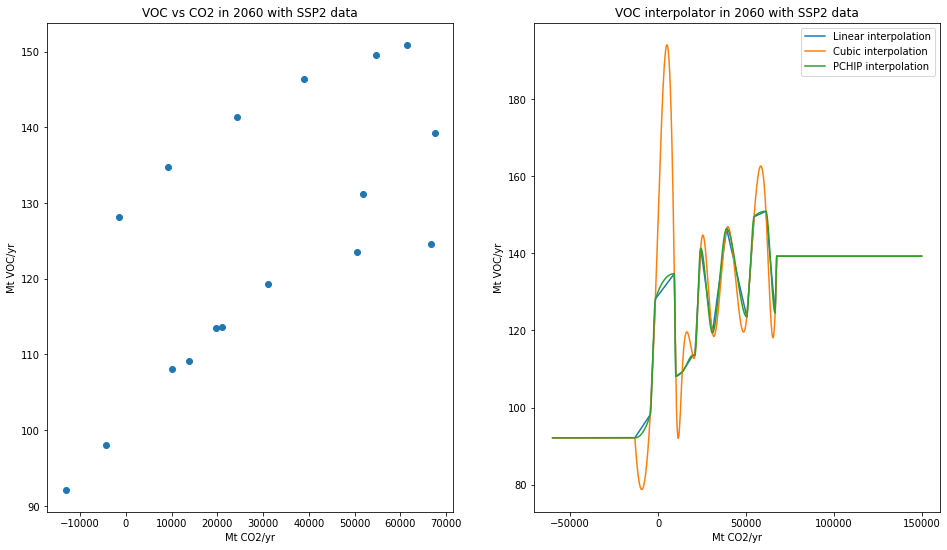

In [13]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
plt.scatter(
    wide_db["Emissions|CO2"].loc[wide_db.index.get_level_values("year") == 2060],
    wide_db["Emissions|VOC"].loc[wide_db.index.get_level_values("year") == 2060],
)
plt.xlabel("Mt CO2/yr")
plt.ylabel("Mt VOC/yr")
ax.set_title("VOC vs CO2 in 2060 with SSP2 data")
ax = fig.add_subplot(122)

xs = np.arange(-60000, 150000)
plt.plot(xs, interpolator[2060](xs))
plt.plot(xs, cubic_interpolator[2060](xs))
plt.plot(xs, pchip_interpolator[2060](xs))
plt.title("VOC interpolator in 2060 with SSP2 data")
plt.xlabel("Mt CO2/yr")
plt.ylabel("Mt VOC/yr")
plt.legend(["Linear interpolation", "Cubic interpolation", "PCHIP interpolation"])

It's immediately apparent that cubic interpolation is easily made to look bad, but PCHIP interpolation is smoother than linear interpolation and may present reasonable results in  this simple case. 
However when applied to even moderately noisy data we get very noisy infilled trend lines (even when we only use linear interpolation):

Text(0.5, 1.0, 'Infilled VOC trends')

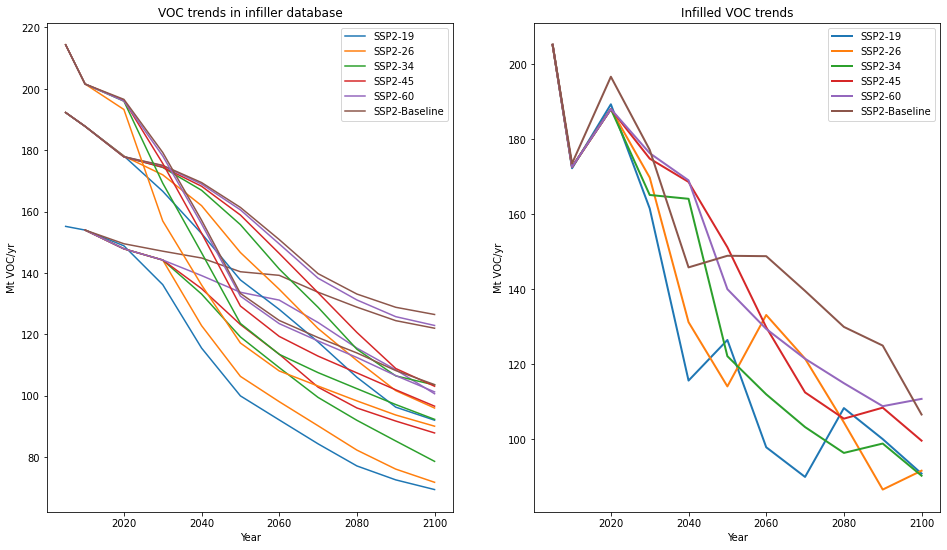

In [14]:
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(121)
too_much_data.filter(scenario="SSP2*", variable="*VOC").plot(ax=ax, color="scenario")
ax.set_title("VOC trends in infiller database")

ax = fig.add_subplot(122)
infilled.plot(ax=ax, **pkwargs)
ax.set_title("Infilled VOC trends")

By contrast, if we choose only the baseline, we get more regular results, albeit with a strong discontinuity. 

In [15]:
baseline = "SSP2-Baseline"
less_data = too_much_data.filter(scenario=baseline)
filler = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], required_scenario=baseline
)
infilled = filler(sr15_data_aim_ssp2)

In [16]:
wide_db = _make_wide_db(less_data)
interpolator = _make_interpolator("Emissions|VOC", ["Emissions|CO2"], wide_db, "year")

Text(0, 0.5, 'Mt VOC/yr')

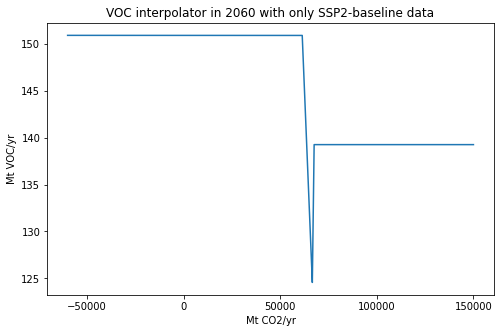

In [17]:
fig = plt.figure(figsize=(8, 5))

xs = np.arange(-60000, 150000)
plt.plot(xs, interpolator[2060](xs))
plt.title("VOC interpolator in 2060 with only SSP2-baseline data")
plt.xlabel("Mt CO2/yr")
plt.ylabel("Mt VOC/yr")

We see the results of this are less chaotic, but more deterministic (most possible values of CO2 are mapped to one of two values). 

Text(0.5, 1.0, 'Infilled VOC trends')

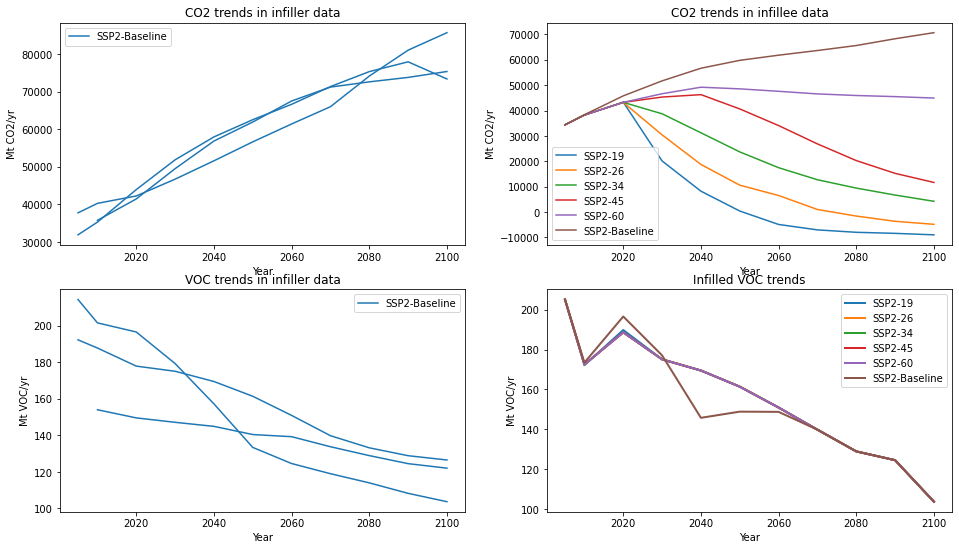

In [18]:
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(221)
less_data.filter(scenario=baseline, variable="*CO2").plot(ax=ax, color="scenario")
ax.set_title("CO2 trends in infiller data")

ax = fig.add_subplot(222)
sr15_data_aim_ssp2.filter(variable="*CO2").plot(ax=ax, color="scenario")
ax.set_title("CO2 trends in infillee data")

ax = fig.add_subplot(223)
less_data.filter(scenario=baseline, variable="*VOC").plot(ax=ax, color="scenario")
ax.set_title("VOC trends in infiller data")

ax = fig.add_subplot(224)
infilled.plot(ax=ax, **pkwargs)
ax.set_title("Infilled VOC trends")

We see that the results are all one of two timeseries, but still irregular. This shows that this is generally not an appropriate model to use unless the infiller model has strong similarities with some specific subset of models or scenarios, and usually we will require both to be restricted. 